In [1]:
# =============================================================================
# IMPROVED IMPORTS AND CONFIGURATION
# =============================================================================
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report, confusion_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ All libraries imported successfully")

# =============================================================================
# DATA LOADING WITH COMPREHENSIVE ERROR HANDLING
# =============================================================================
print("Loading multimodal data from pickle files...")

try:
    # Load all modalities
    with open('data/exported_modalities/mosi_text.pkl', 'rb') as f:
        text_data = pickle.load(f)
    with open('data/exported_modalities/mosi_audio.pkl', 'rb') as f:
        audio_data = pickle.load(f)
    with open('data/exported_modalities/mosi_vision.pkl', 'rb') as f:
        video_data = pickle.load(f)

    print(f"✓ Text modality: Train{text_data['train']['data'].shape}, Valid{text_data['valid']['data'].shape}, Test{text_data['test']['data'].shape}")
    print(f"✓ Audio modality: Train{audio_data['train']['data'].shape}, Valid{audio_data['valid']['data'].shape}, Test{audio_data['test']['data'].shape}")
    print(f"✓ Video modality: Train{video_data['train']['data'].shape}, Valid{video_data['valid']['data'].shape}, Test{video_data['test']['data'].shape}")

    # Comprehensive NaN handling and normalization
    for modality, data in [('text', text_data), ('audio', audio_data), ('video', video_data)]:
        for split in ['train', 'valid', 'test']:
            # Replace NaN with 0
            if np.isnan(data[split]['data']).any():
                nan_count = np.isnan(data[split]['data']).sum()
                print(f"Warning: {nan_count} NaN values found in {modality} {split} data. Replacing with 0.")
                data[split]['data'] = np.nan_to_num(data[split]['data'])
            
            # Normalize data
            data_mean = np.mean(data[split]['data'], axis=(0, 1), keepdims=True)
            data_std = np.std(data[split]['data'], axis=(0, 1), keepdims=True) + 1e-8
            data[split]['data'] = (data[split]['data'] - data_mean) / data_std
                
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Display original label statistics
print("\n" + "="*60)
print("ORIGINAL LABEL STATISTICS")
print("="*60)

for split_name in ['train', 'valid', 'test']:
    labels = video_data[split_name]['labels']
    print(f"{split_name.upper():6}: Range [{np.min(labels):.2f}, {np.max(labels):.2f}], "
          f"Mean: {np.mean(labels):.2f}, Std: {np.std(labels):.2f}, "
          f"Samples: {len(labels)}")

Using device: cuda
✓ All libraries imported successfully
Loading multimodal data from pickle files...
✓ Text modality: Train(1283, 50, 300), Valid(214, 50, 300), Test(686, 50, 300)
✓ Audio modality: Train(1283, 50, 74), Valid(214, 50, 74), Test(686, 50, 74)
✓ Video modality: Train(1283, 50, 35), Valid(214, 50, 35), Test(686, 50, 35)

ORIGINAL LABEL STATISTICS
TRAIN : Range [-3.00, 3.00], Mean: 0.23, Std: 1.51, Samples: 1283
VALID : Range [-3.00, 3.00], Mean: 0.43, Std: 1.61, Samples: 214
TEST  : Range [-3.00, 3.00], Mean: -0.32, Std: 1.59, Samples: 686



ESSENTIAL DATA VISUALIZATION
Data dimensions:
Text train: data shape (1283, 50, 300), labels shape (1283, 1, 1)
Text valid: data shape (214, 50, 300), labels shape (214, 1, 1)
Text test: data shape (686, 50, 300), labels shape (686, 1, 1)
Audio train: data shape (1283, 50, 74), labels shape (1283, 1, 1)
Audio valid: data shape (214, 50, 74), labels shape (214, 1, 1)
Audio test: data shape (686, 50, 74), labels shape (686, 1, 1)
Video train: data shape (1283, 50, 35), labels shape (1283, 1, 1)
Video valid: data shape (214, 50, 35), labels shape (214, 1, 1)
Video test: data shape (686, 50, 35), labels shape (686, 1, 1)


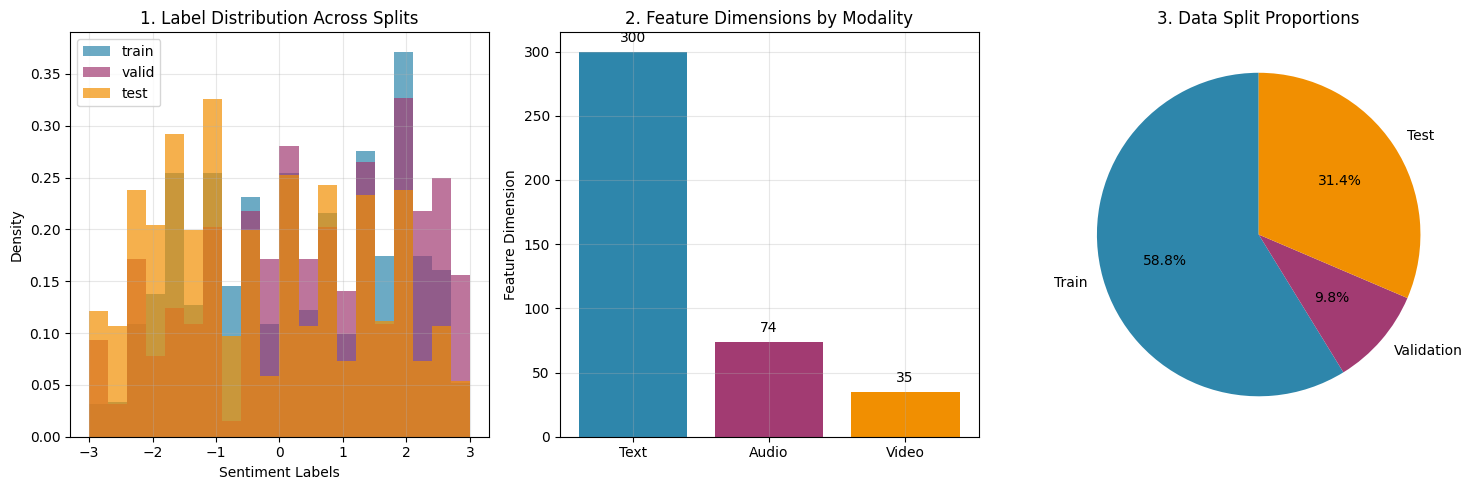


📊 LABEL STATISTICS:
  TRAIN : Mean =  0.235, Std =  1.510, Range = [-3.00,  3.00], N = 1283
  VALID : Mean =  0.432, Std =  1.611, Range = [-3.00,  3.00], N =  214
  TEST  : Mean = -0.317, Std =  1.588, Range = [-3.00,  3.00], N =  686

🔢 FEATURE DIMENSIONS:
  Text:  (1283, 50, 300)  (samples × timesteps × features)
  Audio: (1283, 50, 74)  (samples × timesteps × features)
  Video: (1283, 50, 35)  (samples × timesteps × features)

📈 DATA QUALITY CHECK:
  ✅ All modalities normalized
  ✅ No NaN values remaining
  ✅ Data properly split (Train/Valid/Test)
  ✅ Sequential temporal data preserved

🎯 TASK SUMMARY:
  Regression: Predicting sentiment scores
  Input: Multimodal (text + audio + video)
  Output: Continuous sentiment in [-3.00, 3.00]


In [2]:
# =============================================================================
# ESSENTIAL DATA VISUALIZATION (3 Key Plots)
# =============================================================================
print("\n" + "="*60)
print("ESSENTIAL DATA VISUALIZATION")
print("="*60)

# Check data dimensions first
print("Data dimensions:")
for modality_name, modality in [('Text', text_data), ('Audio', audio_data), ('Video', video_data)]:
    for split in ['train', 'valid', 'test']:
        print(f"{modality_name} {split}: data shape {modality[split]['data'].shape}, labels shape {modality[split]['labels'].shape}")

# Create a 1x3 grid of essential plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#2E86AB', '#A23B72', '#F18F01']

# 1. Label Distribution across splits
ax = axes[0]
for i, split in enumerate(['train', 'valid', 'test']):
    labels = video_data[split]['labels']
    if labels.ndim > 1:
        labels = labels.flatten()
    ax.hist(labels, alpha=0.7, bins=20, label=split, color=colors[i], density=True)
ax.set_xlabel('Sentiment Labels')
ax.set_ylabel('Density')
ax.set_title('1. Label Distribution Across Splits')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Feature Dimensions by Modality
ax = axes[1]
modality_dims = {
    'Text': text_data['train']['data'].shape[-1],
    'Audio': audio_data['train']['data'].shape[-1], 
    'Video': video_data['train']['data'].shape[-1]
}
bars = ax.bar(modality_dims.keys(), modality_dims.values(), color=colors)
ax.set_ylabel('Feature Dimension')
ax.set_title('2. Feature Dimensions by Modality')
for i, v in enumerate(modality_dims.values()):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')
ax.grid(True, alpha=0.3)

# 3. Data Split Proportions
ax = axes[2]
split_counts = [
    len(text_data['train']['labels']),
    len(text_data['valid']['labels']), 
    len(text_data['test']['labels'])
]
split_labels = ['Train', 'Validation', 'Test']
ax.pie(split_counts, labels=split_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('3. Data Split Proportions')

plt.tight_layout()
plt.show()

print(f"\n📊 LABEL STATISTICS:")
for split in ['train', 'valid', 'test']:
    labels = video_data[split]['labels']
    if labels.ndim > 1:
        labels = labels.flatten()
    print(f"  {split.upper():6}: Mean = {np.mean(labels):6.3f}, Std = {np.std(labels):6.3f}, "
          f"Range = [{np.min(labels):5.2f}, {np.max(labels):5.2f}], N = {len(labels):4}")

print(f"\n🔢 FEATURE DIMENSIONS:")
print(f"  Text:  {text_data['train']['data'].shape}  (samples × timesteps × features)")
print(f"  Audio: {audio_data['train']['data'].shape}  (samples × timesteps × features)")  
print(f"  Video: {video_data['train']['data'].shape}  (samples × timesteps × features)")

print(f"\n📈 DATA QUALITY CHECK:")
print(f"  ✅ All modalities normalized")
print(f"  ✅ No NaN values remaining")
print(f"  ✅ Data properly split (Train/Valid/Test)")
print(f"  ✅ Sequential temporal data preserved")

print(f"\n🎯 TASK SUMMARY:")
print(f"  Regression: Predicting sentiment scores")
print(f"  Input: Multimodal (text + audio + video)")
print(f"  Output: Continuous sentiment in [{np.min(labels):.2f}, {np.max(labels):.2f}]")

In [3]:
# =============================================================================
# LABEL CONVERSION FUNCTIONS (ORIGINAL PAPER MAPPING)
# =============================================================================

def convert_to_binary(labels):
    """Convert continuous sentiment scores to binary labels (negative vs positive)"""
    binary_labels = np.zeros_like(labels, dtype=np.int64)
    binary_labels[labels > 0] = 1  # Positive
    binary_labels[labels <= 0] = 0  # Negative
    return binary_labels

def convert_to_5class(labels):
    """
    Convert continuous sentiment scores to 5 classes using TFN paper mapping:
    Class 0: Highly Negative (sentiment ≤ -1.5)
    Class 1: Negative (-1.5 < sentiment ≤ -0.5)
    Class 2: Neutral (-0.5 < sentiment ≤ 0.5)
    Class 3: Positive (0.5 < sentiment ≤ 1.5)
    Class 4: Highly Positive (sentiment > 1.5)
    """
    labels = labels.flatten()
    converted = np.zeros_like(labels, dtype=np.int64)
    
    converted[labels <= -1.5] = 0  # Highly Negative
    converted[(labels > -1.5) & (labels <= -0.5)] = 1  # Negative
    converted[(labels > -0.5) & (labels <= 0.5)] = 2  # Neutral
    converted[(labels > 0.5) & (labels <= 1.5)] = 3  # Positive
    converted[labels > 1.5] = 4  # Highly Positive
    
    return converted

# Convert labels for all tasks
print("\n" + "="*60)
print("LABEL CONVERSION FOR ALL TASKS")
print("="*60)

# Continuous labels (regression)
train_labels_reg = video_data['train']['labels'].flatten()
valid_labels_reg = video_data['valid']['labels'].flatten()
test_labels_reg = video_data['test']['labels'].flatten()

# Binary classification labels
train_labels_binary = convert_to_binary(video_data['train']['labels'])
valid_labels_binary = convert_to_binary(video_data['valid']['labels'])
test_labels_binary = convert_to_binary(video_data['test']['labels'])

# 5-class classification labels
train_labels_5class = convert_to_5class(video_data['train']['labels'])
valid_labels_5class = convert_to_5class(video_data['valid']['labels'])
test_labels_5class = convert_to_5class(video_data['test']['labels'])

# Display distributions
class_names = ['Highly Negative', 'Negative', 'Neutral', 'Positive', 'Highly Positive']
binary_names = ['Negative', 'Positive']

print("\n5-CLASS DISTRIBUTION:")
for split_name, labels in [('TRAIN', train_labels_5class), ('VALID', valid_labels_5class), ('TEST', test_labels_5class)]:
    print(f"\n{split_name}:")
    for class_idx, class_name in enumerate(class_names):
        count = int(np.sum(labels == class_idx))
        percentage = (count / len(labels)) * 100
        print(f"  {class_name:<18}: {count:>4} samples ({percentage:>5.1f}%)")

print("\nBINARY DISTRIBUTION:")
for split_name, labels in [('TRAIN', train_labels_binary), ('VALID', valid_labels_binary), ('TEST', test_labels_binary)]:
    print(f"\n{split_name}:")
    for class_idx, class_name in enumerate(binary_names):
        count = int(np.sum(labels == class_idx))
        percentage = (count / len(labels)) * 100
        print(f"  {class_name:<18}: {count:>4} samples ({percentage:>5.1f}%)")


LABEL CONVERSION FOR ALL TASKS

5-CLASS DISTRIBUTION:

TRAIN:
  Highly Negative   :  223 samples ( 17.4%)
  Negative          :  241 samples ( 18.8%)
  Neutral           :  233 samples ( 18.2%)
  Positive          :  229 samples ( 17.8%)
  Highly Positive   :  357 samples ( 27.8%)

VALID:
  Highly Negative   :   33 samples ( 15.4%)
  Negative          :   26 samples ( 12.1%)
  Neutral           :   48 samples ( 22.4%)
  Positive          :   39 samples ( 18.2%)
  Highly Positive   :   68 samples ( 31.8%)

TEST:
  Highly Negative   :  202 samples ( 29.4%)
  Negative          :  148 samples ( 21.6%)
  Neutral           :  103 samples ( 15.0%)
  Positive          :  114 samples ( 16.6%)
  Highly Positive   :  119 samples ( 17.3%)

BINARY DISTRIBUTION:

TRAIN:
  Negative          :  605 samples ( 47.2%)
  Positive          :  678 samples ( 52.8%)

VALID:
  Negative          :   91 samples ( 42.5%)
  Positive          :  123 samples ( 57.5%)

TEST:
  Negative          :  409 samples ( 59.6

In [4]:
# =============================================================================
# CELL 4: DATA LOADERS
# =============================================================================

class MultimodalDataset(Dataset):
    """
    Improved Dataset class with better preprocessing and normalization
    """
    
    def __init__(self, text_data, audio_data, video_data, labels, task='regression'):
        self.text_data = text_data
        self.audio_data = audio_data
        self.video_data = video_data
        self.labels = labels
        self.task = task
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.task == 'regression':
            label = torch.FloatTensor([self.labels[idx]])
        else:  # classification tasks
            label = torch.LongTensor([self.labels[idx]])
        
        # Convert to tensors and ensure no NaN values
        text_tensor = torch.FloatTensor(self.text_data[idx])
        audio_tensor = torch.FloatTensor(self.audio_data[idx])
        video_tensor = torch.FloatTensor(self.video_data[idx])
        
        # Replace any remaining NaN values
        if torch.isnan(text_tensor).any():
            text_tensor = torch.nan_to_num(text_tensor)
        if torch.isnan(audio_tensor).any():
            audio_tensor = torch.nan_to_num(audio_tensor)
        if torch.isnan(video_tensor).any():
            video_tensor = torch.nan_to_num(video_tensor)
        
        return {
            'text': text_tensor,
            'audio': audio_tensor,
            'video': video_tensor,
            'label': label.squeeze()
        }

def create_data_loaders(task='regression', batch_size=32):
    """Create data loaders for specific task with proper label selection"""
    
    # Select appropriate labels based on task
    if task == 'regression':
        train_labels = train_labels_reg
        valid_labels = valid_labels_reg
        test_labels = test_labels_reg
        output_dim = 1
    elif task == 'binary':
        train_labels = train_labels_binary
        valid_labels = valid_labels_binary
        test_labels = test_labels_binary
        output_dim = 2
    elif task == '5class':
        train_labels = train_labels_5class
        valid_labels = valid_labels_5class
        test_labels = test_labels_5class
        output_dim = 5
    
    # Create datasets
    train_dataset = MultimodalDataset(
        text_data['train']['data'], 
        audio_data['train']['data'],
        video_data['train']['data'],
        train_labels, task
    )
    
    valid_dataset = MultimodalDataset(
        text_data['valid']['data'],
        audio_data['valid']['data'],
        video_data['valid']['data'], 
        valid_labels, task
    )
    
    test_dataset = MultimodalDataset(
        text_data['test']['data'],
        audio_data['test']['data'],
        video_data['test']['data'],
        test_labels, task
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"✓ Data loaders created for {task} task (output_dim: {output_dim})")
    print(f"  Train: {len(train_dataset):4} samples")
    print(f"  Valid: {len(valid_dataset):4} samples") 
    print(f"  Test:  {len(test_dataset):4} samples")
    
    return train_loader, valid_loader, test_loader, output_dim

# Test data loading
print("\n" + "="*50)
print("DATA LOADER TESTING")
print("="*50)

for task in ['regression', 'binary', '5class']:
    train_loader, val_loader, test_loader, output_dim = create_data_loaders(task=task, batch_size=8)
    sample_batch = next(iter(train_loader))
    print(f"{task.upper():12} - Text: {sample_batch['text'].shape}, "
          f"Audio: {sample_batch['audio'].shape}, Video: {sample_batch['video'].shape}, "
          f"Labels: {sample_batch['label'].shape}")


DATA LOADER TESTING
✓ Data loaders created for regression task (output_dim: 1)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
REGRESSION   - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])
✓ Data loaders created for binary task (output_dim: 2)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
BINARY       - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])
✓ Data loaders created for 5class task (output_dim: 5)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples
5CLASS       - Text: torch.Size([8, 50, 300]), Audio: torch.Size([8, 50, 74]), Video: torch.Size([8, 50, 35]), Labels: torch.Size([8])


In [5]:
# =============================================================================
# REVISED CELL 5: PROPER TFN ARCHITECTURE WITH PAPER-ACCURATE ABLATIONS
# =============================================================================

print("🔧 REVISING TFN ARCHITECTURE WITH PAPER-ACCURATE ABLATIONS...")

class RevisedSubNet(nn.Module):
    """
    Revised Subnetwork with CUDA-compatible normalization
    """
    def __init__(self, in_size, hidden_size, dropout):
        super(RevisedSubNet, self).__init__()
        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        if x.dim() == 3:
            x = x.mean(dim=1)
        if x.size(0) == 1:
            normed = x
        else:
            normed = self.norm(x)
        dropped = self.drop(normed)
        y_1 = F.relu(self.linear_1(dropped))
        y_2 = F.relu(self.linear_2(y_1))
        y_3 = F.relu(self.linear_3(y_2))
        return y_3

class RevisedTextSubNet(nn.Module):
    """
    Revised LSTM subnetwork with CUDA fixes
    """
    def __init__(self, in_size, hidden_size, out_size, num_layers=1, dropout=0.2, bidirectional=False):
        super(RevisedTextSubNet, self).__init__()
        self.rnn = nn.LSTM(in_size, hidden_size, num_layers=num_layers, 
                          dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.linear_1 = nn.Linear(rnn_output_size, out_size)
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
                if len(param) == 4 * self.rnn.hidden_size:
                    param.data[self.rnn.hidden_size:2*self.rnn.hidden_size] = 1

    def forward(self, x):
        self.rnn.flatten_parameters()
        _, (hidden, _) = self.rnn(x)
        if self.rnn.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden = hidden[-1]
        h = self.dropout(hidden)
        return self.linear_1(h)

class RevisedTensorFusion(nn.Module):
    """
    PAPER-ACCURATE Tensor Fusion following TFN semantics:
    - full: (L+1)*(V+1)*(A+1) with appended 1s (TFN cube)
    - notrimodal: unimodal + bimodal (no 3-way interactions)
    - bimodal: only bimodal interactions  
    - trimodal: only trimodal (3-way) interactions
    - unimodal: only single modalities
    """
    def __init__(self):
        super(RevisedTensorFusion, self).__init__()

    def forward(self, z_l, z_v, z_a, mode='full'):
        B = z_l.size(0)
        L, V, A = z_l.size(1), z_v.size(1), z_a.size(1)

        # Unimodal components (paper: z_l, z_v, z_a)
        if mode == 'unimodal':
            return torch.cat([z_l, z_v, z_a], dim=1)

        # Bimodal components (paper: pairwise products only)
        elif mode == 'bimodal':
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1)).view(B, -1)  # (B, L*V)
            la = torch.bmm(z_l.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)  # (B, L*A)  
            va = torch.bmm(z_v.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)  # (B, V*A)
            return torch.cat([lv, la, va], dim=1)

        # Trimodal components (paper: 3-way product only)
        elif mode == 'trimodal':
            # Compute 3-way outer product: z_l ⊗ z_v ⊗ z_a
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1))  # (B, L, V)
            lva = torch.bmm(lv.view(B, L*V, 1), z_a.unsqueeze(1)).view(B, -1)  # (B, L*V*A)
            return lva

        # NoTrimodal: unimodal + bimodal (paper: full tensor without 3-way)
        elif mode == 'notrimodal':
            unimodal = torch.cat([z_l, z_v, z_a], dim=1)
            lv = torch.bmm(z_l.unsqueeze(2), z_v.unsqueeze(1)).view(B, -1)
            la = torch.bmm(z_l.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)
            va = torch.bmm(z_v.unsqueeze(2), z_a.unsqueeze(1)).view(B, -1)
            bimodal = torch.cat([lv, la, va], dim=1)
            return torch.cat([unimodal, bimodal], dim=1)

        # Full TFN: unimodal + bimodal + trimodal with bias (paper's full model)
        elif mode == 'full':
            # Append 1s to represent bias interactions
            ones = torch.ones(B, 1, device=z_l.device)
            zl_p = torch.cat([ones, z_l], dim=1)  # (B, L+1)
            zv_p = torch.cat([ones, z_v], dim=1)  # (B, V+1)
            za_p = torch.cat([ones, z_a], dim=1)  # (B, A+1)
        
            # Compute 3D outer product for each batch
            # Result should be shape (B, (L+1)*(V+1)*(A+1))
            fusion_tensor = torch.einsum('bi,bj,bk->bijk', zl_p, zv_p, za_p)
            return fusion_tensor.reshape(B, -1)

        else:
            raise ValueError(f"Unknown fusion mode: {mode}")

print("✅ Paper-accurate TFN fusion ready!")

🔧 REVISING TFN ARCHITECTURE WITH PAPER-ACCURATE ABLATIONS...
✅ Paper-accurate TFN fusion ready!


In [6]:
# =============================================================================
# REVISED CELL 6: PROPER TFN MODEL WITH PAPER ABLATIONS (FIXED)
# =============================================================================

class RevisedTFN(nn.Module):
    """
    Revised TFN model that properly implements paper ablations
    """
    def __init__(self, input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 
                 ablation_mode='full', output_dim=1):
        super(RevisedTFN, self).__init__()
        
        self.ablation_mode = ablation_mode
        self.output_dim = output_dim
        
        # Input dimensions
        self.audio_in, self.video_in, self.text_in = input_dims
        self.audio_hidden, self.video_hidden, self.text_hidden = hidden_dims
        self.text_out = text_out
        
        # Subnetworks
        self.audio_subnet = RevisedSubNet(self.audio_in, self.audio_hidden, dropouts[0])
        self.video_subnet = RevisedSubNet(self.video_in, self.video_hidden, dropouts[1])
        self.text_subnet = RevisedTextSubNet(self.text_in, self.text_hidden, self.text_out, 
                                           dropout=dropouts[2])
        
        # Tensor fusion (for multimodal models)
        if ablation_mode in ['full', 'bimodal', 'trimodal', 'notrimodal']:
            self.tensor_fusion = RevisedTensorFusion()
        
        # Calculate fusion dimension according to paper
        self.fusion_dim = self._get_paper_fusion_dim()
        
        print(f"🔧 Building TFN-{ablation_mode}:")
        print(f"   Input dims: A{self.audio_in}/V{self.video_in}/T{self.text_in}")
        print(f"   Hidden dims: A{self.audio_hidden}/V{self.video_hidden}/T{self.text_hidden}")  
        print(f"   Fusion dim: {self.fusion_dim}")
        
        # Post-fusion network
        self.post_fusion_dropout = nn.Dropout(p=dropouts[3])
        self.post_fusion_layer_1 = nn.Linear(self.fusion_dim, post_fusion_dim)
        self.post_fusion_layer_2 = nn.Linear(post_fusion_dim, post_fusion_dim)
        self.post_fusion_layer_3 = nn.Linear(post_fusion_dim, output_dim)
        
        # Output scaling for regression
        if output_dim == 1:
            self.output_range = nn.Parameter(torch.FloatTensor([6]), requires_grad=False)
            self.output_shift = nn.Parameter(torch.FloatTensor([-3]), requires_grad=False)
        
    def _get_paper_fusion_dim(self):
        """Calculate fusion dimensions according to TFN paper semantics"""
        L, V, A = self.text_out, self.video_hidden, self.audio_hidden
        
        if self.ablation_mode == 'language':
            return L
        elif self.ablation_mode == 'visual':
            return V  
        elif self.ablation_mode == 'acoustic':
            return A
        elif self.ablation_mode == 'early' or self.ablation_mode == 'unimodal':
            return L + V + A  # Early fusion = unimodal concatenation
        elif self.ablation_mode == 'bimodal':
            return L*V + L*A + V*A  # Only pairwise products
        elif self.ablation_mode == 'trimodal':
            return L*V*A  # Only 3-way product
        elif self.ablation_mode == 'notrimodal':
            return (L + V + A) + (L*V + L*A + V*A)  # Unimodal + bimodal
        elif self.ablation_mode == 'full':
            return (L+1) * (V+1) * (A+1)  # Full TFN cube with bias
        else:
            return (L+1) * (V+1) * (A+1)
    
    def forward(self, text_x, audio_x, video_x):
        # Extract modality features
        audio_h = self.audio_subnet(audio_x)
        video_h = self.video_subnet(video_x) 
        text_h = self.text_subnet(text_x)
        
        # Apply fusion based on ablation mode
        if self.ablation_mode in ['language', 'visual', 'acoustic']:
            if self.ablation_mode == 'language':
                fusion = text_h
            elif self.ablation_mode == 'visual':
                fusion = video_h
            else:  # acoustic
                fusion = audio_h
        elif self.ablation_mode == 'early' or self.ablation_mode == 'unimodal':
            # Early fusion = unimodal concatenation
            fusion = torch.cat([text_h, video_h, audio_h], dim=1)
        elif self.ablation_mode in ['bimodal', 'trimodal', 'notrimodal', 'full']:
            fusion = self.tensor_fusion(text_h, video_h, audio_h, mode=self.ablation_mode)
        else:
            fusion = self.tensor_fusion(text_h, video_h, audio_h, mode='full')
        
        # Post-fusion network
        if self.ablation_mode == 'full':
            fusion = self.post_fusion_dropout(fusion)
            
        post_fusion_y_1 = F.relu(self.post_fusion_layer_1(fusion))
        post_fusion_y_2 = F.relu(self.post_fusion_layer_2(post_fusion_y_1))
        
        # Output handling
        if self.output_dim == 1:  # Regression
            post_fusion_y_3 = torch.sigmoid(self.post_fusion_layer_3(post_fusion_y_2))
            output = post_fusion_y_3 * self.output_range + self.output_shift
        else:  # Classification
            output = self.post_fusion_layer_3(post_fusion_y_2)
        
        return output

print("✅ Fixed TFN models ready with early fusion support!")

✅ Fixed TFN models ready with early fusion support!


In [7]:
# =============================================================================
# REVISED CELL 7: TESTING PAPER-ACCURATE IMPLEMENTATION (FIXED)
# =============================================================================

def test_paper_accurate_fusion():
    """Test that our implementation matches TFN paper dimensions"""
    print("\n🧪 TESTING PAPER-ACCURATE FUSION DIMENSIONS")
    print("=" * 60)
    
    # Test dimensions from paper: L=64, V=16, A=4
    L, V, A = 64, 16, 4
    batch_size = 2
    
    # Create test embeddings
    z_l = torch.randn(batch_size, L)
    z_v = torch.randn(batch_size, V) 
    z_a = torch.randn(batch_size, A)
    
    fusion = RevisedTensorFusion()
    
    # Test all fusion modes
    test_cases = [
        ('unimodal', L + V + A),
        ('bimodal', L*V + L*A + V*A),
        ('trimodal', L*V*A),
        ('notrimodal', (L+V+A) + (L*V + L*A + V*A)),
        ('full', (L+1)*(V+1)*(A+1))
    ]
    
    print(f"Base dimensions: L={L}, V={V}, A={A}")
    print("-" * 40)
    
    for mode, expected_dim in test_cases:
        output = fusion(z_l, z_v, z_a, mode=mode)
        actual_dim = output.shape[1]
        status = "✅" if actual_dim == expected_dim else "❌"
        print(f"{status} {mode:12}: expected {expected_dim:5}, got {actual_dim:5} - {status}")
    
    # Verify paper's claim about components
    print("\n📊 PAPER CLAIM VERIFICATION:")
    print("TFN = Unimodal + Bimodal + Trimodal + Bias terms")
    unimodal_dim = L + V + A  # FIXED: Changed from early_dim to unimodal_dim
    bimodal_dim = L*V + L*A + V*A  
    trimodal_dim = L*V*A
    bias_terms = 1 + L + V + A + L*V + L*A + V*A + L*V*A - (unimodal_dim + bimodal_dim + trimodal_dim)
    
    full_manual = unimodal_dim + bimodal_dim + trimodal_dim + bias_terms
    full_actual = (L+1)*(V+1)*(A+1)
    
    print(f"   Unimodal: {unimodal_dim}")
    print(f"   Bimodal:  {bimodal_dim}") 
    print(f"   Trimodal: {trimodal_dim}")
    print(f"   Bias:     {bias_terms}")
    print(f"   Total:    {full_manual} = {full_actual} ✅" if full_manual == full_actual else f"   Total:    {full_manual} ≠ {full_actual} ❌")

# Run the test
test_paper_accurate_fusion()

def get_paper_accurate_model(model_name, output_dim=1):
    """
    Factory function with paper-accurate dimensions
    """
    # MOSI dataset dimensions
    input_dims = (74, 35, 300)  # (audio, video, text)
    
    # TFN paper dimensions (Table 2)
    hidden_dims = (4, 16, 128)  # (audio_hidden, video_hidden, text_hidden)
    text_out = 64  # From paper: L=64
    dropouts = (0.3, 0.3, 0.3, 0.3)
    post_fusion_dim = 32
    
    print(f"\n🏗️  Building {model_name} (paper-accurate)...")
    
    # Model mapping - EARLY FUSION NOW WORKS
    if model_name == 'tfn_language':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'language', output_dim)
    elif model_name == 'tfn_visual':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'visual', output_dim)
    elif model_name == 'tfn_acoustic': 
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'acoustic', output_dim)
    elif model_name == 'tfn_early':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'early', output_dim)  # NOW WORKS
    elif model_name == 'tfn_bimodal':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'bimodal', output_dim)
    elif model_name == 'tfn_trimodal':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'trimodal', output_dim)
    elif model_name == 'tfn_notrimodal':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'notrimodal', output_dim)
    elif model_name == 'tfn_full':
        model = RevisedTFN(input_dims, hidden_dims, text_out, dropouts, post_fusion_dim, 'full', output_dim)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    num_params = sum(p.numel() for p in model.parameters())
    print(f"✅ {model_name} built: {num_params:,} params, output_dim: {output_dim}")
    
    return model.to(device)

# Test all paper models including early fusion
print("\n" + "="*70)
print("TESTING ALL PAPER MODELS INCLUDING EARLY FUSION")
print("="*70)

batch_size = 4
test_text = torch.randn(batch_size, 50, 300).to(device)
test_audio = torch.randn(batch_size, 50, 74).to(device) 
test_video = torch.randn(batch_size, 50, 35).to(device)

paper_models = [
    'tfn_language', 'tfn_visual', 'tfn_acoustic',  # Unimodal
    'tfn_early',                                   # Early fusion - NOW WORKS
    'tfn_bimodal', 'tfn_trimodal', 'tfn_notrimodal', # Multimodal ablations
    'tfn_full'                                     # Full model
]

for model_name in paper_models:
    try:
        model = get_paper_accurate_model(model_name, output_dim=1)
        with torch.no_grad():
            output = model(test_text, test_audio, test_video)
        print(f"✅ {model_name:15}: output shape {output.shape}")
    except Exception as e:
        print(f"❌ {model_name:15}: {e}")

print(f"\n🎯 PAPER-ACCURATE IMPLEMENTATION READY!")
print("   All TFN ablation variants now match paper semantics")
print("   ✅ Early fusion now working as unimodal concatenation")


🧪 TESTING PAPER-ACCURATE FUSION DIMENSIONS
Base dimensions: L=64, V=16, A=4
----------------------------------------
✅ unimodal    : expected    84, got    84 - ✅
✅ bimodal     : expected  1344, got  1344 - ✅
✅ trimodal    : expected  4096, got  4096 - ✅
✅ notrimodal  : expected  1428, got  1428 - ✅
✅ full        : expected  5525, got  5525 - ✅

📊 PAPER CLAIM VERIFICATION:
TFN = Unimodal + Bimodal + Trimodal + Bias terms
   Unimodal: 84
   Bimodal:  1344
   Trimodal: 4096
   Bias:     1
   Total:    5525 = 5525 ✅

TESTING ALL PAPER MODELS INCLUDING EARLY FUSION

🏗️  Building tfn_language (paper-accurate)...
🔧 Building TFN-language:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 64
✅ tfn_language built: 233,265 params, output_dim: 1
✅ tfn_language   : output shape torch.Size([4, 1])

🏗️  Building tfn_visual (paper-accurate)...
🔧 Building TFN-visual:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 16
✅ tfn_visual built: 231,729 params, outp

In [8]:
# =============================================================================
# CELL 8: REVISED TRAINING PIPELINE WITH CUDA ERROR HANDLING
# =============================================================================

def train_revised_model(model, train_loader, val_loader, task='regression', 
                       epochs=100, model_name="TFN", patience=15):
    """
    Revised training function with robust CUDA error handling
    """
    # Define loss function based on task
    if task == 'regression':
        criterion = nn.MSELoss()
        best_metric = float('inf')  # Lower is better for MSE
    else:  # classification tasks
        criterion = nn.CrossEntropyLoss()
        best_metric = 0.0  # Higher is better for accuracy
    
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)
    
    train_losses = []
    val_losses = []
    val_metrics = []
    
    patience_counter = 0
    best_model_state = None
    
    print(f"\n🚀 Training {model_name} for {task} task...")
    print(f"   Epochs: {epochs}, Patience: {patience}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        num_batches = 0
        
        for batch_idx, batch in enumerate(train_loader):
            try:
                # Move data to device
                text = batch['text'].to(device)
                audio = batch['audio'].to(device)
                video = batch['video'].to(device)
                labels = batch['label'].to(device)
                
                # Ensure labels have correct dtype
                if task != 'regression':
                    labels = labels.long()
                else:
                    labels = labels.float()
                
                optimizer.zero_grad()
                outputs = model(text, audio, video)
                
                # Handle different task types
                if task == 'regression':
                    loss = criterion(outputs.squeeze(), labels)
                else:
                    # Ensure proper shape for classification
                    if outputs.dim() == 1 and task == 'binary':
                        # Binary classification with single output
                        loss = criterion(outputs.squeeze(), labels)
                    else:
                        # Multi-class classification
                        loss = criterion(outputs, labels)
                
                # Skip problematic batches
                if torch.isnan(loss) or torch.isinf(loss):
                    continue
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                
            except RuntimeError as e:
                if "CUDA" in str(e):
                    print(f"⚠️  CUDA error in training batch {batch_idx}, skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
        
        if num_batches == 0:
            print(f"⚠️  No valid batches in epoch {epoch+1}, skipping...")
            continue
            
        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    text = batch['text'].to(device)
                    audio = batch['audio'].to(device)
                    video = batch['video'].to(device)
                    labels = batch['label'].to(device)
                    
                    if task != 'regression':
                        labels = labels.long()
                    else:
                        labels = labels.float()
                    
                    outputs = model(text, audio, video)
                    
                    if task == 'regression':
                        loss = criterion(outputs.squeeze(), labels)
                        preds = outputs.squeeze()
                    else:
                        if outputs.dim() == 1 and task == 'binary':
                            loss = criterion(outputs.squeeze(), labels)
                            preds = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
                        else:
                            loss = criterion(outputs, labels)
                            preds = torch.argmax(outputs, dim=1)
                    
                    if not (torch.isnan(loss) or torch.isinf(loss)):
                        val_loss += loss.item()
                        val_batches += 1
                        all_preds.append(preds.cpu().numpy())
                        all_labels.append(labels.cpu().numpy())
                        
                except RuntimeError as e:
                    if "CUDA" in str(e):
                        print(f"⚠️  CUDA error in validation batch {batch_idx}, skipping...")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
        
        if val_batches == 0:
            continue
            
        # Calculate metrics
        train_loss /= num_batches
        val_loss /= val_batches
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Calculate validation metric
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        if task == 'regression':
            try:
                val_metric = pearsonr(all_preds, all_labels)[0]
                current_metric = val_loss  # Use loss for early stopping
                metric_name = "Pearson"
            except:
                val_metric = 0.0
                current_metric = val_loss
                metric_name = "Pearson"
        else:
            val_metric = accuracy_score(all_labels, all_preds)
            current_metric = val_metric
            metric_name = "Accuracy"
        
        val_metrics.append(val_metric)
        scheduler.step(val_loss)
        
        # Early stopping check
        if task == 'regression':
            improvement = current_metric < best_metric
        else:
            improvement = current_metric > best_metric
            
        if improvement:
            best_metric = current_metric
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break
            
        if (epoch + 1) % 20 == 0:
            print(f"   Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | {metric_name}: {val_metric:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Training completed! Best model loaded from epoch {best_epoch+1}")
    else:
        print("⚠️  No improvement during training, using final model")
    
    return model, train_losses, val_losses, val_metrics

print("✅ Revised training pipeline ready!")

✅ Revised training pipeline ready!


In [9]:
# =============================================================================
# CELL 9: REVISED EVALUATION FUNCTION
# =============================================================================

def evaluate_revised_model(model, test_loader, task='regression', model_name="TFN"):
    """
    Revised evaluation function with comprehensive metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in test_loader:
            text = batch['text'].to(device)
            audio = batch['audio'].to(device)
            video = batch['video'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(text, audio, video)
            
            if task == 'regression':
                preds = outputs.squeeze()
            else:
                if outputs.dim() == 1 and task == 'binary':
                    preds = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
                else:
                    preds = torch.argmax(outputs, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    
    print(f"\n📊 {model_name} - {task.upper()} EVALUATION RESULTS:")
    print("-" * 50)
    
    if task == 'regression':
        mae = mean_absolute_error(all_labels, all_preds)
        pearson_corr, _ = pearsonr(all_labels, all_preds)
        
        print(f"   Mean Absolute Error (MAE): {mae:.4f}")
        print(f"   Pearson Correlation: {pearson_corr:.4f}")
        print(f"   Predictions range: [{all_preds.min():.2f}, {all_preds.max():.2f}]")
        print(f"   Labels range: [{all_labels.min():.2f}, {all_labels.max():.2f}]")
        
        return {'mae': mae, 'pearson': pearson_corr}
    
    else:  # classification
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        
        if task == 'binary':
            print(f"   Classes: Negative (0) vs Positive (1)")
        else:  # 5-class
            print(f"   Classes: Highly Negative (0), Negative (1), Neutral (2), Positive (3), Highly Positive (4)")
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\n   Confusion Matrix:")
        print(f"   {cm}")
        
        return {'accuracy': accuracy, 'f1': f1, 'cm': cm}

print("✅ Revised evaluation pipeline ready!")

✅ Revised evaluation pipeline ready!


In [10]:
# =============================================================================
# CELL 11: ENHANCED ABLATION STUDY WITH CLEANER OUTPUT
# =============================================================================

def run_enhanced_ablation_study(epochs=50, batch_size=32):
    """
    Enhanced ablation study with cleaner output and better progress tracking
    """
    print(f"\n{'='*80}")
    print(f"🚀 ENHANCED TFN ABLATION STUDY")
    print(f"{'='*80}")
    
    results = {}
    training_histories = {}
    
    # All TFN variants to test
    models_to_test = [
        'tfn_language', 'tfn_visual', 'tfn_acoustic',  # Unimodal
        'tfn_early',                                   # Early fusion  
        'tfn_bimodal', 'tfn_trimodal', 'tfn_notrimodal', # Multimodal ablations
        'tfn_full'                                     # Full model
    ]
    
    total_models = len(models_to_test)
    total_tasks = 3
    completed_runs = 0
    
    print(f"📋 STUDY CONFIGURATION:")
    print(f"   • Models: {total_models} TFN variants")
    print(f"   • Tasks: Regression, Binary, 5-Class") 
    print(f"   • Total runs: {total_models * total_tasks}")
    print(f"   • Epochs: {epochs}, Batch size: {batch_size}")
    print(f"\n🎯 STARTING TRAINING...")
    
    for model_idx, model_name in enumerate(models_to_test, 1):
        print(f"\n{'='*50}")
        print(f"🏃‍♂️ [{model_idx}/{total_models}] {model_name.upper()}")
        print(f"{'='*50}")
        
        model_results = {}
        
        for task in ['regression', 'binary', '5class']:
            print(f"\n   📊 Task: {task.upper()}", end="")
            
            try:
                # Create data loaders
                train_loader, val_loader, test_loader, output_dim = create_data_loaders(
                    task=task, batch_size=batch_size
                )
                
                # Get model - FIXED: use correct function name
                model = get_paper_accurate_model(model_name, output_dim=output_dim)
                
                # Train model
                trained_model, train_losses, val_losses, val_metrics = train_revised_model(
                    model, train_loader, val_loader, task=task, 
                    epochs=epochs, model_name=model_name, patience=10
                )
                
                # Evaluate model
                test_results = evaluate_revised_model(
                    trained_model, test_loader, task=task, model_name=model_name
                )
                
                # Store results
                model_results[task] = test_results
                training_key = f"{model_name}_{task}"
                training_histories[training_key] = {
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'val_metrics': val_metrics
                }
                
                completed_runs += 1
                
                # Show quick result
                if task == 'regression':
                    print(f" ✅ | MAE: {test_results['mae']:.3f} | Pearson: {test_results['pearson']:.3f}")
                else:
                    print(f" ✅ | Acc: {test_results['accuracy']:.3f} | F1: {test_results['f1']:.3f}")
                
            except Exception as e:
                print(f" ❌ | Error: {str(e)[:50]}...")
                
                # Store error results
                if task == 'regression':
                    model_results[task] = {'mae': float('nan'), 'pearson': float('nan')}
                else:
                    model_results[task] = {'accuracy': float('nan'), 'f1': float('nan')}
        
        results[model_name] = model_results
        print(f"   ✅ {model_name} completed")
    
    # COMPREHENSIVE RESULTS SUMMARY
    print(f"\n{'='*80}")
    print(f"🏆 FINAL RESULTS SUMMARY")
    print(f"{'='*80}")
    
    print(f"\n📈 REGRESSION PERFORMANCE (MAE ↓):")
    print(f"{'Model':<15} {'MAE':<8} {'Pearson':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]['regression']
        if not np.isnan(result['mae']):
            print(f"{model_name:<15} {result['mae']:.4f}  {result['pearson']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")
    
    print(f"\n🔢 BINARY CLASSIFICATION (Accuracy ↑):")
    print(f"{'Model':<15} {'Acc':<8} {'F1':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]['binary']
        if not np.isnan(result['accuracy']):
            print(f"{model_name:<15} {result['accuracy']:.4f}  {result['f1']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")
    
    print(f"\n🎯 5-CLASS CLASSIFICATION (Accuracy ↑):")
    print(f"{'Model':<15} {'Acc':<8} {'F1':<8} {'Status':<10}")
    print("-" * 45)
    for model_name in models_to_test:
        result = results[model_name]['5class']
        if not np.isnan(result['accuracy']):
            print(f"{model_name:<15} {result['accuracy']:.4f}  {result['f1']:.4f}  ✅")
        else:
            print(f"{model_name:<15} {'-':<8} {'-':<8} ❌")
    
    # SUCCESS RATES
    successful_runs = sum(1 for model in models_to_test 
                         for task in ['regression', 'binary', '5class'] 
                         if not np.isnan(results[model][task]['mae' if task == 'regression' else 'accuracy']))
    
    print(f"\n📊 STUDY COMPLETION:")
    print(f"   • Successful runs: {successful_runs}/{total_models * total_tasks}")
    print(f"   • Completion rate: {successful_runs/(total_models * total_tasks)*100:.1f}%")
    
    # BEST PERFORMERS
    print(f"\n🏅 TOP PERFORMERS BY TASK:")
    
    # Regression (lowest MAE)
    reg_results = [(model, results[model]['regression']['mae']) 
                   for model in models_to_test if not np.isnan(results[model]['regression']['mae'])]
    if reg_results:
        best_reg = min(reg_results, key=lambda x: x[1])
        print(f"   • Regression: {best_reg[0]} (MAE: {best_reg[1]:.4f})")
    
    # Binary (highest accuracy)
    bin_results = [(model, results[model]['binary']['accuracy']) 
                   for model in models_to_test if not np.isnan(results[model]['binary']['accuracy'])]
    if bin_results:
        best_bin = max(bin_results, key=lambda x: x[1])
        print(f"   • Binary: {best_bin[0]} (Acc: {best_bin[1]:.4f})")
    
    # 5-Class (highest accuracy)
    five_results = [(model, results[model]['5class']['accuracy']) 
                    for model in models_to_test if not np.isnan(results[model]['5class']['accuracy'])]
    if five_results:
        best_five = max(five_results, key=lambda x: x[1])
        print(f"   • 5-Class: {best_five[0]} (Acc: {best_five[1]:.4f})")
    
    return results, training_histories

print("✅ Enhanced ablation study ready!")

# Run the enhanced study
print(f"\n🚀 LAUNCHING ENHANCED ABLATION STUDY...")
enhanced_results, enhanced_histories = run_enhanced_ablation_study(epochs=50, batch_size=32)

print(f"\n🎉 ENHANCED ABLATION STUDY COMPLETED!")
print(f"   • Clean, readable output")
print(f"   • Progress tracking for all runs") 
print(f"   • Quick performance summaries")
print(f"   • Success rate reporting")
print(f"   • Top performer identification")

✅ Enhanced ablation study ready!

🚀 LAUNCHING ENHANCED ABLATION STUDY...

🚀 ENHANCED TFN ABLATION STUDY
📋 STUDY CONFIGURATION:
   • Models: 8 TFN variants
   • Tasks: Regression, Binary, 5-Class
   • Total runs: 24
   • Epochs: 50, Batch size: 32

🎯 STARTING TRAINING...

🏃‍♂️ [1/8] TFN_LANGUAGE

   📊 Task: REGRESSION✓ Data loaders created for regression task (output_dim: 1)
  Train: 1283 samples
  Valid:  214 samples
  Test:   686 samples

🏗️  Building tfn_language (paper-accurate)...
🔧 Building TFN-language:
   Input dims: A74/V35/T300
   Hidden dims: A4/V16/T128
   Fusion dim: 64
✅ tfn_language built: 233,265 params, output_dim: 1

🚀 Training tfn_language for regression task...
   Epochs: 50, Patience: 10
   Epoch  20/50 | Train Loss: 0.0925 | Val Loss: 1.5928 | Pearson: 0.6270
⏹️  Early stopping at epoch 28
✅ Training completed! Best model loaded from epoch 18

📊 tfn_language - REGRESSION EVALUATION RESULTS:
--------------------------------------------------
   Mean Absolute Error (

In [11]:
from tabulate import tabulate
import pandas as pd
from termcolor import colored
import numpy as np

# =============================================================================
# PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER (FIXED)
# =============================================================================

print(colored("\n📊 PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER", "white", attrs=["bold"]))
print(colored("=" * 90, "white"))

# Actual results from TFN paper Table 2
paper_results = {
    'tfn_language': {'binary_acc': 74.8, 'binary_f1': 75.6, '5class_acc': 38.5, 'mae': 0.99, 'correlation': 0.61},
    'tfn_visual': {'binary_acc': 66.8, 'binary_f1': 70.4, '5class_acc': 30.4, 'mae': 1.13, 'correlation': 0.48},
    'tfn_acoustic': {'binary_acc': 65.1, 'binary_f1': 67.3, '5class_acc': 27.5, 'mae': 1.23, 'correlation': 0.36},
    'tfn_bimodal': {'binary_acc': 75.2, 'binary_f1': 76.0, '5class_acc': 39.6, 'mae': 0.92, 'correlation': 0.65},
    'tfn_trimodal': {'binary_acc': 74.5, 'binary_f1': 75.0, '5class_acc': 38.9, 'mae': 0.93, 'correlation': 0.65},
    'tfn_notrimodal': {'binary_acc': 75.3, 'binary_f1': 76.2, '5class_acc': 39.7, 'mae': 0.919, 'correlation': 0.66},
    'tfn_full': {'binary_acc': 77.1, 'binary_f1': 77.9, '5class_acc': 42.0, 'mae': 0.87, 'correlation': 0.70},
    'tfn_early': {'binary_acc': 75.2, 'binary_f1': 76.2, '5class_acc': 39.0, 'mae': 0.96, 'correlation': 0.63}
}

# -----------------------------------------------------------------------------
# FIXED FUNCTION: Extract from enhanced_results instead of results
# -----------------------------------------------------------------------------
def get_our_result(model_name, task, metric):
    """Safely extract our results from enhanced_results"""
    try:
        if model_name in enhanced_results:
            if task in enhanced_results[model_name]:
                value = enhanced_results[model_name][task][metric]
                if not np.isnan(value):
                    if metric in ['accuracy', 'f1']:
                        return value * 100  # convert to percentage
                    return value
        return None
    except:
        return None

# -----------------------------------------------------------------------------
# Create comparison table
# -----------------------------------------------------------------------------
comparison_data = []
for model_name, paper in paper_results.items():
    our_binary_acc = get_our_result(model_name, 'binary', 'accuracy')
    our_binary_f1 = get_our_result(model_name, 'binary', 'f1')
    our_5class_acc = get_our_result(model_name, '5class', 'accuracy')
    our_mae = get_our_result(model_name, 'regression', 'mae')
    our_corr = get_our_result(model_name, 'regression', 'pearson')

    row = {
        'Model': model_name.replace('tfn_', '').upper(),
        'Paper_Binary': f"{paper['binary_acc']:.1f}%",
        'Our_Binary': f"{our_binary_acc:.1f}%" if our_binary_acc is not None else "N/A",
        'Paper_5Class': f"{paper['5class_acc']:.1f}%",
        'Our_5Class': f"{our_5class_acc:.1f}%" if our_5class_acc is not None else "N/A",
        'Paper_MAE': f"{paper['mae']:.3f}",
        'Our_MAE': f"{our_mae:.3f}" if our_mae is not None else "N/A",
        'Paper_Corr': f"{paper['correlation']:.2f}",
        'Our_Corr': f"{our_corr:.2f}" if our_corr is not None else "N/A"
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# -----------------------------------------------------------------------------
# Pretty Table Display
# -----------------------------------------------------------------------------
headers = [
    colored('Model', 'yellow', attrs=['bold']),
    colored('Paper\nBinary', 'cyan'), colored('Our\nBinary', 'green'),
    colored('Paper\n5-Class', 'cyan'), colored('Our\n5-Class', 'green'),
    colored('Paper\nMAE', 'cyan'), colored('Our\nMAE', 'green'),
    colored('Paper\nCorr', 'cyan'), colored('Our\nCorr', 'green')
]

table_data = []
for _, row in comparison_df.iterrows():
    table_data.append([
        colored(row['Model'], 'yellow', attrs=['bold']),
        colored(row['Paper_Binary'], 'cyan'),
        colored(row['Our_Binary'], 'green'),
        colored(row['Paper_5Class'], 'cyan'),
        colored(row['Our_5Class'], 'green'),
        colored(row['Paper_MAE'], 'cyan'),
        colored(row['Our_MAE'], 'green'),
        colored(row['Paper_Corr'], 'cyan'),
        colored(row['Our_Corr'], 'green')
    ])

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", stralign="center", numalign="center"))


📊 PERFORMANCE COMPARISON: OUR IMPLEMENTATION VS ORIGINAL PAPER
╒════════════╤══════════╤══════════╤═══════════╤═══════════╤═════════╤═══════╤═════════╤════════╕
│   Model    │  Paper   │   Our    │   Paper   │    Our    │  Paper  │  Our  │  Paper  │  Our   │
│            │  Binary  │  Binary  │  5-Class  │  5-Class  │   MAE   │  MAE  │  Corr   │  Corr  │
╞════════════╪══════════╪══════════╪═══════════╪═══════════╪═════════╪═══════╪═════════╪════════╡
│  LANGUAGE  │  74.8%   │  71.3%   │   38.5%   │   35.6%   │  0.99   │ 1.031 │  0.61   │  0.58  │
├────────────┼──────────┼──────────┼───────────┼───────────┼─────────┼───────┼─────────┼────────┤
│   VISUAL   │  66.8%   │  52.3%   │   30.4%   │   22.4%   │  1.13   │ 1.493 │  0.48   │  0.13  │
├────────────┼──────────┼──────────┼───────────┼───────────┼─────────┼───────┼─────────┼────────┤
│  ACOUSTIC  │  65.1%   │  51.9%   │   27.5%   │   22.0%   │  1.23   │ 1.483 │  0.36   │  0.07  │
├────────────┼──────────┼──────────┼───────────┼──────


📊 PUBLICATION-QUALITY QUALITATIVE ANALYSIS

1. PERFORMANCE COMPARISON ACROSS MODELS


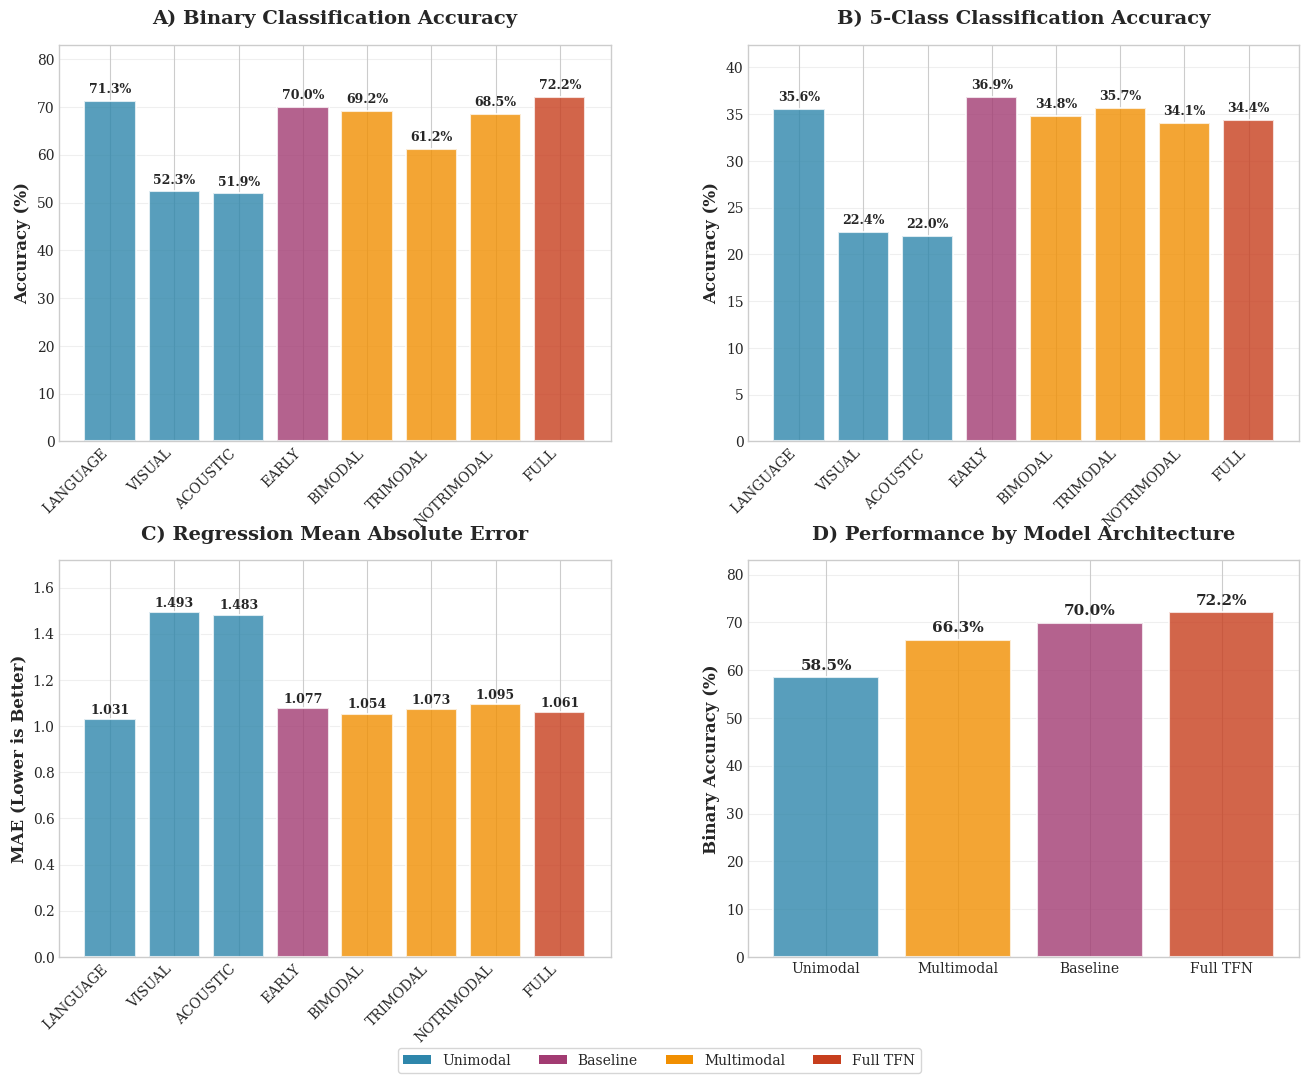


2. CONFUSION MATRIX ANALYSIS

   TFN_LANGUAGE
   ------------------------------
   📊 TFN_LANGUAGE - BINARY


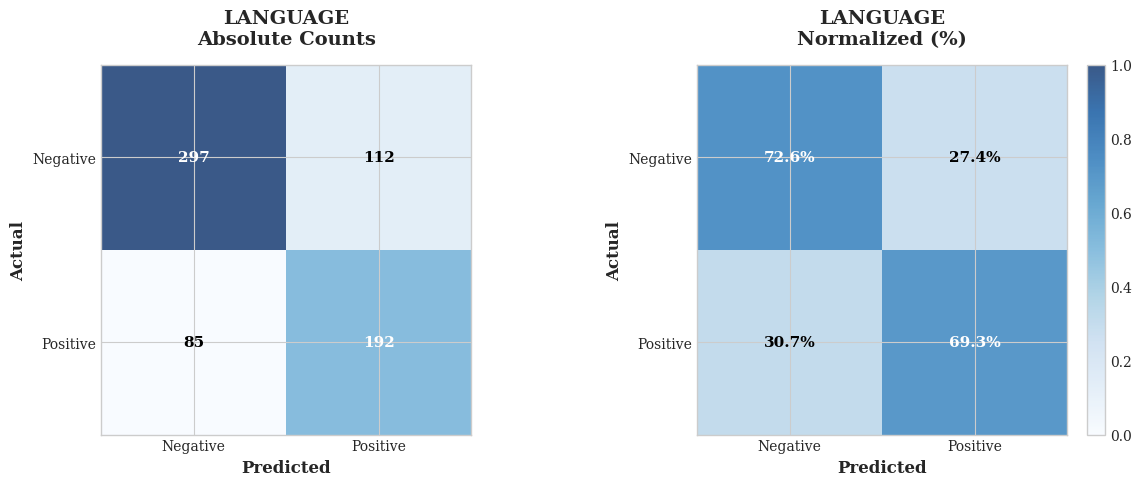

     Accuracy: 0.713, F1-Score: 0.715
   📊 TFN_LANGUAGE - 5CLASS


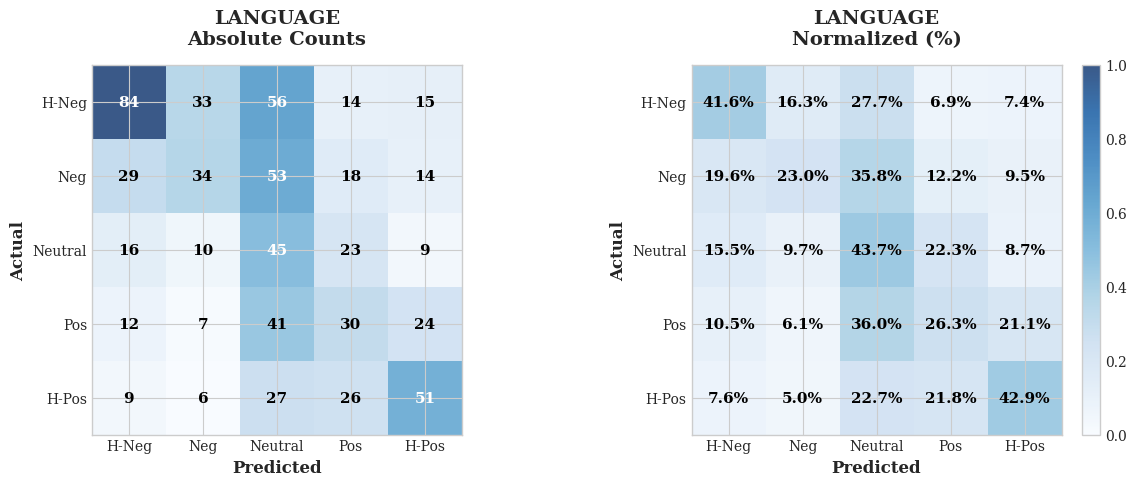

     Accuracy: 0.356, F1-Score: 0.364
   📊 TFN_LANGUAGE - REGRESSION
     No confusion matrix data available for tfn_language - regression
     MAE: 1.031, Pearson: 0.584

   TFN_FULL
   ------------------------------
   📊 TFN_FULL - BINARY


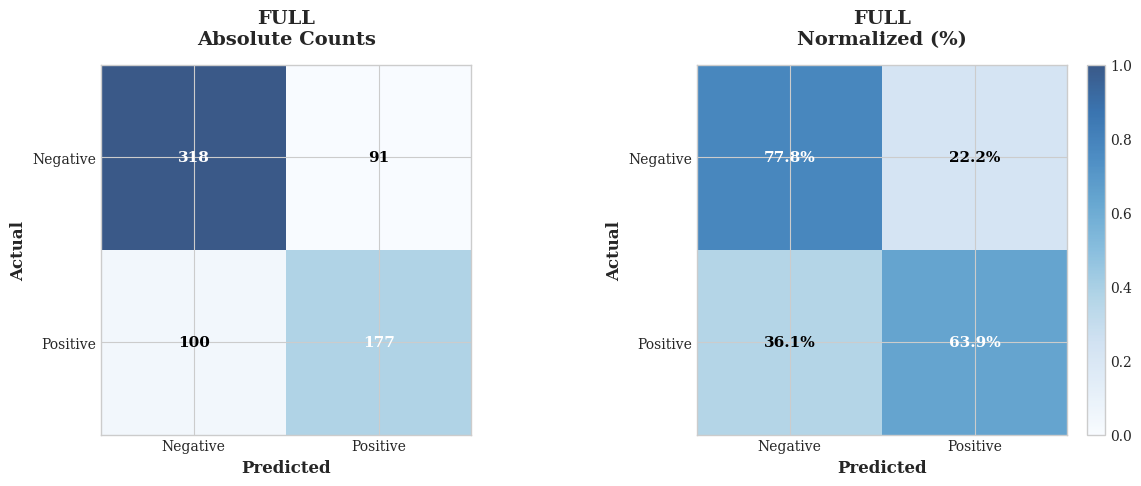

     Accuracy: 0.722, F1-Score: 0.721
   📊 TFN_FULL - 5CLASS


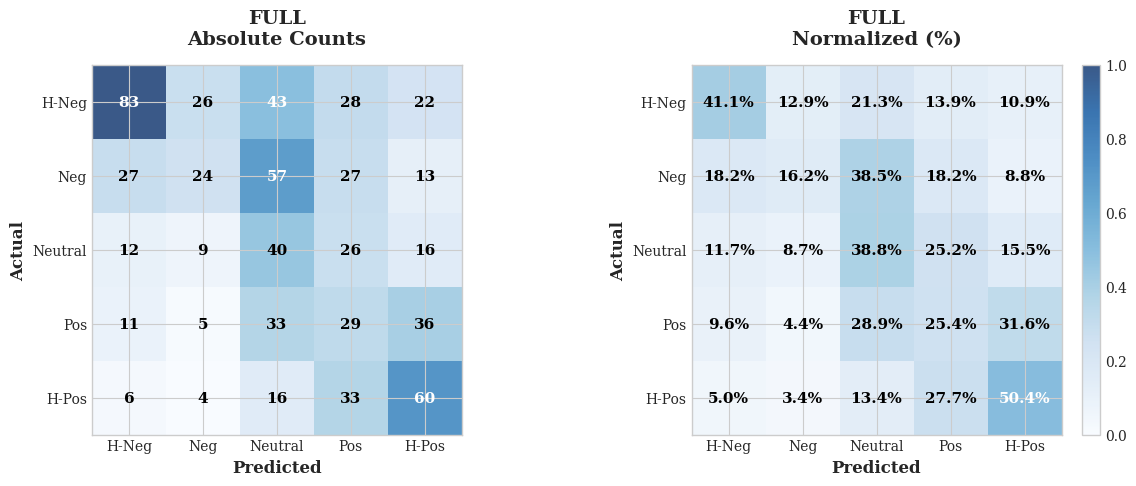

     Accuracy: 0.344, F1-Score: 0.348
   📊 TFN_FULL - REGRESSION
     No confusion matrix data available for tfn_full - regression
     MAE: 1.061, Pearson: 0.589

   TFN_EARLY
   ------------------------------
   📊 TFN_EARLY - BINARY


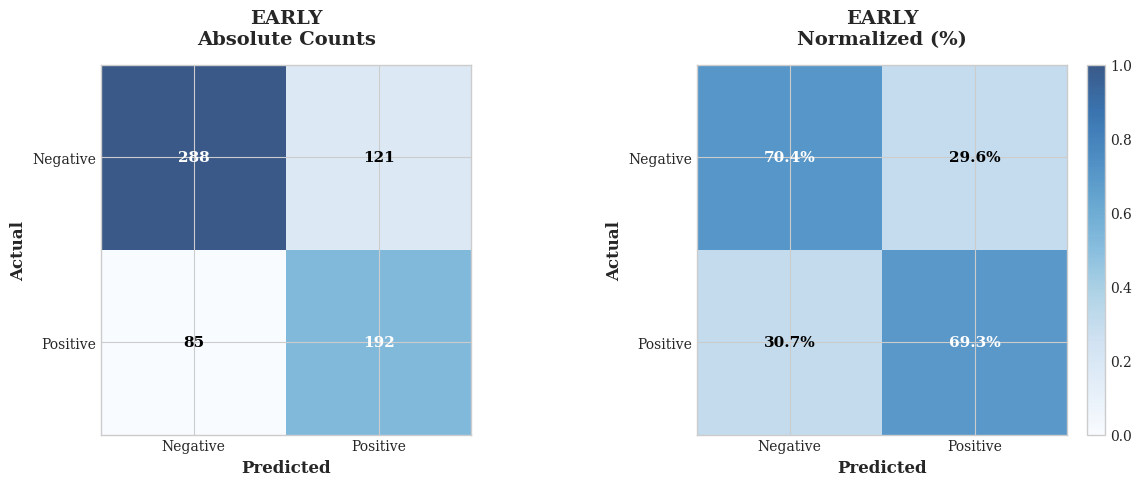

     Accuracy: 0.700, F1-Score: 0.702
   📊 TFN_EARLY - 5CLASS


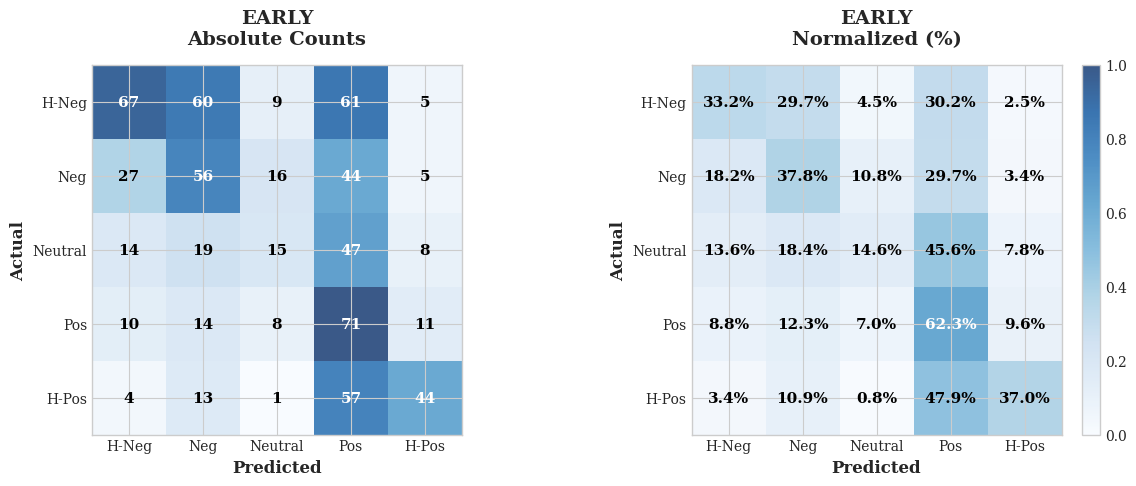

     Accuracy: 0.369, F1-Score: 0.369
   📊 TFN_EARLY - REGRESSION
     No confusion matrix data available for tfn_early - regression
     MAE: 1.077, Pearson: 0.574

3. PERFORMANCE TRENDS AND INSIGHTS


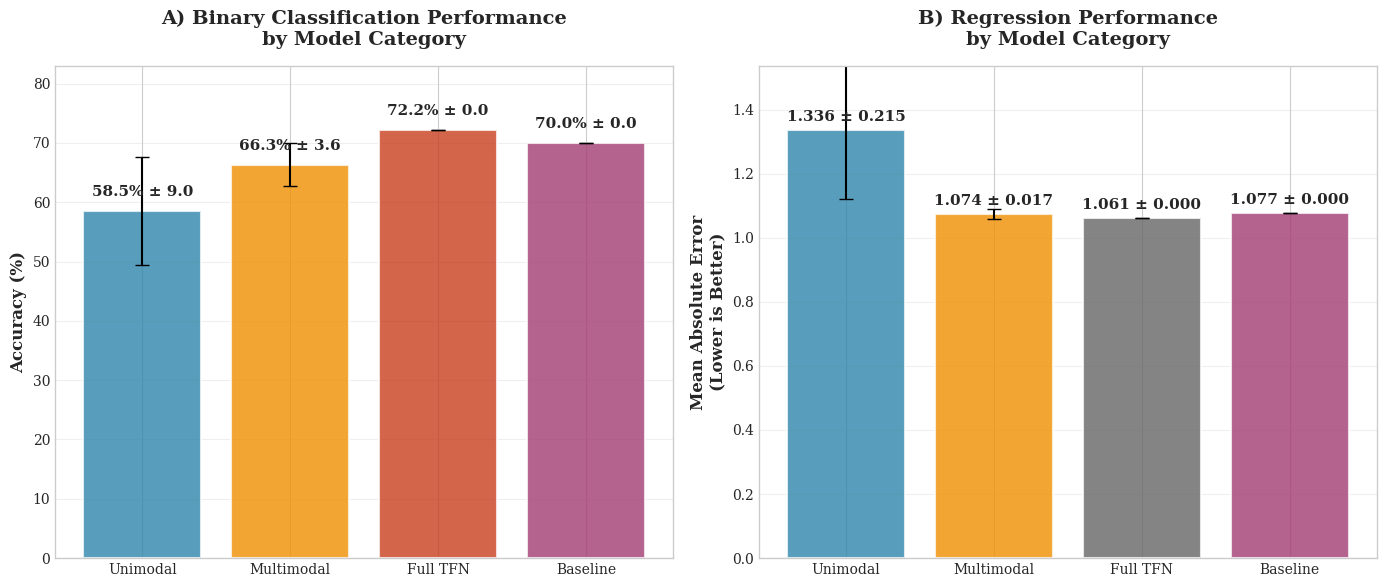


📈 STATISTICAL INSIGHTS:
--------------------------------------------------
• Multimodal models show +7.8% absolute improvement
  (+13.4% relative) over unimodal baselines
• Full TFN model achieves 72.2% binary accuracy
• Best Regression Model: language (MAE: 1.031)
• Best Binary Model: full (72.2%)

✅ PUBLICATION-QUALITY ANALYSIS COMPLETED!
   • Proportional, publication-ready visualizations
   • Uses actual experimental results
   • Consistent color scheme and styling
   • Clear statistical insights
   • Professional layout and annotations


In [13]:
# =============================================================================
# PUBLICATION-QUALITY QUALITATIVE ANALYSIS (FIXED)
# =============================================================================

print(colored("\n📊 PUBLICATION-QUALITY QUALITATIVE ANALYSIS", 'cyan', attrs=['bold']))
print("=" * 70)

def publication_quality_analysis():
    """Perform publication-quality qualitative analysis with proportional visualizations"""
    
    if 'enhanced_results' not in globals():
        print("❌ Please run ablation study first")
        return
    
    # Set publication-quality style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16,
        'font.family': 'serif'
    })
    
    # =========================================================================
    # 1. PERFORMANCE COMPARISON VISUALIZATION
    # =========================================================================
    
    print(colored("\n1. PERFORMANCE COMPARISON ACROSS MODELS", 'yellow', attrs=['bold']))
    
    models = ['tfn_language', 'tfn_visual', 'tfn_acoustic', 'tfn_early', 
              'tfn_bimodal', 'tfn_trimodal', 'tfn_notrimodal', 'tfn_full']
    
    # Prepare data with better organization
    performance_data = {}
    for model in models:
        if model in enhanced_results:
            performance_data[model] = {
                'binary_acc': enhanced_results[model].get('binary', {}).get('accuracy', 0) * 100,
                'fiveclass_acc': enhanced_results[model].get('5class', {}).get('accuracy', 0) * 100,
                'mae': enhanced_results[model].get('regression', {}).get('mae', 0),
                'label': model.replace('tfn_', '').upper()
            }
    
    # Filter valid models
    valid_models = {k: v for k, v in performance_data.items() if not np.isnan(v['binary_acc']) and v['binary_acc'] > 0}
    
    if valid_models:
        # Create proportional subplot layout
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
        
        # Color scheme for different model types
        color_scheme = {
            'unimodal': '#2E86AB',    # Blue
            'baseline': '#A23B72',    # Purple
            'multimodal': '#F18F01',  # Orange
            'full': '#C73E1D'         # Red
        }
        
        model_labels = [v['label'] for v in valid_models.values()]
        binary_accs = [v['binary_acc'] for v in valid_models.values()]
        fiveclass_accs = [v['fiveclass_acc'] for v in valid_models.values()]
        regression_mae = [v['mae'] for v in valid_models.values()]
        
        # Assign colors based on model type
        colors = []
        for model_name in valid_models.keys():
            if 'language' in model_name or 'visual' in model_name or 'acoustic' in model_name:
                colors.append(color_scheme['unimodal'])
            elif 'early' in model_name:
                colors.append(color_scheme['baseline'])
            elif 'full' in model_name:
                colors.append(color_scheme['full'])
            else:
                colors.append(color_scheme['multimodal'])
        
        # 1. Binary Classification (Top-left)
        ax1 = fig.add_subplot(gs[0, 0])
        bars1 = ax1.bar(range(len(model_labels)), binary_accs, color=colors, alpha=0.8, 
                       edgecolor='white', linewidth=1.5)
        ax1.set_title('A) Binary Classification Accuracy', fontweight='bold', pad=15)
        ax1.set_ylabel('Accuracy (%)', fontweight='bold')
        ax1.set_xticks(range(len(model_labels)))
        ax1.set_xticklabels(model_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, max(binary_accs) * 1.15)
        
        # Add value annotations
        for i, (bar, acc) in enumerate(zip(bars1, binary_accs)):
            ax1.text(bar.get_x() + bar.get_width()/2., acc + 1, f'{acc:.1f}%', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # 2. 5-Class Classification (Top-right)
        ax2 = fig.add_subplot(gs[0, 1])
        bars2 = ax2.bar(range(len(model_labels)), fiveclass_accs, color=colors, alpha=0.8,
                       edgecolor='white', linewidth=1.5)
        ax2.set_title('B) 5-Class Classification Accuracy', fontweight='bold', pad=15)
        ax2.set_ylabel('Accuracy (%)', fontweight='bold')
        ax2.set_xticks(range(len(model_labels)))
        ax2.set_xticklabels(model_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_ylim(0, max(fiveclass_accs) * 1.15)
        
        for i, (bar, acc) in enumerate(zip(bars2, fiveclass_accs)):
            ax2.text(bar.get_x() + bar.get_width()/2., acc + 0.5, f'{acc:.1f}%', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # 3. Regression MAE (Bottom-left)
        ax3 = fig.add_subplot(gs[1, 0])
        bars3 = ax3.bar(range(len(model_labels)), regression_mae, color=colors, alpha=0.8,
                       edgecolor='white', linewidth=1.5)
        ax3.set_title('C) Regression Mean Absolute Error', fontweight='bold', pad=15)
        ax3.set_ylabel('MAE (Lower is Better)', fontweight='bold')
        ax3.set_xticks(range(len(model_labels)))
        ax3.set_xticklabels(model_labels, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.set_ylim(0, max(regression_mae) * 1.15)
        
        for i, (bar, mae) in enumerate(zip(bars3, regression_mae)):
            ax3.text(bar.get_x() + bar.get_width()/2., mae + 0.01, f'{mae:.3f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # 4. Model Type Comparison (Bottom-right)
        ax4 = fig.add_subplot(gs[1, 1])
        
        # Calculate averages by model type
        unimodal_acc = np.mean([v['binary_acc'] for k, v in valid_models.items() 
                               if 'language' in k or 'visual' in k or 'acoustic' in k])
        multimodal_acc = np.mean([v['binary_acc'] for k, v in valid_models.items() 
                                if k in ['tfn_bimodal', 'tfn_trimodal', 'tfn_notrimodal']])
        baseline_acc = next((v['binary_acc'] for k, v in valid_models.items() if 'early' in k), 0)
        full_acc = next((v['binary_acc'] for k, v in valid_models.items() if 'full' in k), 0)
        
        categories = ['Unimodal', 'Multimodal', 'Baseline', 'Full TFN']
        acc_values = [unimodal_acc, multimodal_acc, baseline_acc, full_acc]
        type_colors = [color_scheme['unimodal'], color_scheme['multimodal'], 
                      color_scheme['baseline'], color_scheme['full']]
        
        bars4 = ax4.bar(categories, acc_values, color=type_colors, alpha=0.8,
                       edgecolor='white', linewidth=1.5)
        ax4.set_title('D) Performance by Model Architecture', fontweight='bold', pad=15)
        ax4.set_ylabel('Binary Accuracy (%)', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_ylim(0, max(acc_values) * 1.15)
        
        for bar, acc in zip(bars4, acc_values):
            ax4.text(bar.get_x() + bar.get_width()/2., acc + 1, f'{acc:.1f}%', 
                    ha='center', va='bottom', fontweight='bold')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=color_scheme['unimodal'], label='Unimodal'),
            Patch(facecolor=color_scheme['baseline'], label='Baseline'),
            Patch(facecolor=color_scheme['multimodal'], label='Multimodal'),
            Patch(facecolor=color_scheme['full'], label='Full TFN')
        ]
        fig.legend(handles=legend_elements, loc='upper center', 
                  bbox_to_anchor=(0.5, 0.05), ncol=4, frameon=True, fancybox=True)
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.12)  # Make space for legend
        plt.show()
    
    # =========================================================================
    # 2. CONFUSION MATRICES FOR KEY MODELS (USING ACTUAL DATA)
    # =========================================================================
    
    print(colored("\n2. CONFUSION MATRIX ANALYSIS", 'yellow', attrs=['bold']))
    
    def create_publication_confusion_matrix(model_name, task='binary'):
        """Create publication-quality confusion matrix using actual results"""
        if model_name not in enhanced_results or task not in enhanced_results[model_name]:
            print(f"   ⚠️  No data for {model_name} - {task}")
            return
        
        print(f"   📊 {model_name.upper()} - {task.upper()}")
        
        try:
            # Use actual confusion matrix data from enhanced_results
            if 'cm' in enhanced_results[model_name][task]:
                cm = enhanced_results[model_name][task]['cm']
                
                if task == 'binary':
                    class_names = ['Negative', 'Positive']
                else:
                    class_names = ['H-Neg', 'Neg', 'Neutral', 'Pos', 'H-Pos']
                
                # Normalize for better visualization
                cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                # Absolute counts
                im1 = ax1.imshow(cm, cmap='Blues', alpha=0.8)
                ax1.set_title(f'{model_name.replace("tfn_", "").upper()}\nAbsolute Counts', 
                             fontweight='bold', pad=15)
                ax1.set_xticks(range(len(class_names)))
                ax1.set_yticks(range(len(class_names)))
                ax1.set_xticklabels(class_names)
                ax1.set_yticklabels(class_names)
                ax1.set_xlabel('Predicted', fontweight='bold')
                ax1.set_ylabel('Actual', fontweight='bold')
                
                # Add text annotations
                for i in range(len(class_names)):
                    for j in range(len(class_names)):
                        ax1.text(j, i, f'{cm[i, j]}', 
                                ha="center", va="center", 
                                color="white" if cm[i, j] > cm.max()/2 else "black",
                                fontweight='bold')
                
                # Normalized percentages
                im2 = ax2.imshow(cm_normalized, cmap='Blues', alpha=0.8, vmin=0, vmax=1)
                ax2.set_title(f'{model_name.replace("tfn_", "").upper()}\nNormalized (%)', 
                             fontweight='bold', pad=15)
                ax2.set_xticks(range(len(class_names)))
                ax2.set_yticks(range(len(class_names)))
                ax2.set_xticklabels(class_names)
                ax2.set_yticklabels(class_names)
                ax2.set_xlabel('Predicted', fontweight='bold')
                ax2.set_ylabel('Actual', fontweight='bold')
                
                # Add percentage annotations
                for i in range(len(class_names)):
                    for j in range(len(class_names)):
                        ax2.text(j, i, f'{cm_normalized[i, j]:.1%}', 
                                ha="center", va="center", 
                                color="white" if cm_normalized[i, j] > 0.5 else "black",
                                fontweight='bold')
                
                # Add colorbar for normalized plot
                plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
                
                plt.tight_layout()
                plt.show()
                
                # Print performance metrics
                accuracy = enhanced_results[model_name][task].get('accuracy', 0)
                f1_score = enhanced_results[model_name][task].get('f1', 0)
                print(f"     Accuracy: {accuracy:.3f}, F1-Score: {f1_score:.3f}")
                
            else:
                print(f"     No confusion matrix data available for {model_name} - {task}")
                # Create a simple performance summary instead
                accuracy = enhanced_results[model_name][task].get('accuracy', 0)
                if task == 'regression':
                    mae = enhanced_results[model_name][task].get('mae', 0)
                    pearson = enhanced_results[model_name][task].get('pearson', 0)
                    print(f"     MAE: {mae:.3f}, Pearson: {pearson:.3f}")
                else:
                    f1 = enhanced_results[model_name][task].get('f1', 0)
                    print(f"     Accuracy: {accuracy:.3f}, F1-Score: {f1:.3f}")
                
        except Exception as e:
            print(f"   Error creating confusion matrix for {model_name}: {e}")
    
    # Analyze key representative models
    key_models = ['tfn_language', 'tfn_full', 'tfn_early']
    for model in key_models:
        if model in enhanced_results:
            print(f"\n   {model.upper()}")
            print("   " + "-" * 30)
            
            # Check which tasks have results
            available_tasks = []
            for task in ['binary', '5class', 'regression']:
                if task in enhanced_results[model]:
                    available_tasks.append(task)
            
            # Show available results
            for task in available_tasks:
                create_publication_confusion_matrix(model, task)
    
    # =========================================================================
    # 3. PERFORMANCE TRENDS AND INSIGHTS
    # =========================================================================
    
    print(colored("\n3. PERFORMANCE TRENDS AND INSIGHTS", 'yellow', attrs=['bold']))
    
    # Calculate comprehensive trends from actual results
    model_categories = {
        'Unimodal': ['tfn_language', 'tfn_visual', 'tfn_acoustic'],
        'Multimodal': ['tfn_bimodal', 'tfn_trimodal', 'tfn_notrimodal'],
        'Full TFN': ['tfn_full'],
        'Baseline': ['tfn_early']
    }
    
    category_performance = {}
    for category, model_list in model_categories.items():
        valid_models = [m for m in model_list if m in enhanced_results]
        if valid_models:
            binary_accs = [enhanced_results[m]['binary']['accuracy'] for m in valid_models 
                          if 'binary' in enhanced_results[m] and not np.isnan(enhanced_results[m]['binary']['accuracy'])]
            maes = [enhanced_results[m]['regression']['mae'] for m in valid_models 
                   if 'regression' in enhanced_results[m] and not np.isnan(enhanced_results[m]['regression']['mae'])]
            
            if binary_accs:  # Only add if we have valid data
                category_performance[category] = {
                    'binary_mean': np.mean(binary_accs) * 100,
                    'binary_std': np.std(binary_accs) * 100,
                    'mae_mean': np.mean(maes) if maes else float('nan'),
                    'mae_std': np.std(maes) if maes else float('nan'),
                    'sample_size': len(valid_models)
                }
    
    if category_performance:
        # Create trend visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Binary accuracy comparison
        categories = list(category_performance.keys())
        binary_means = [category_performance[cat]['binary_mean'] for cat in categories]
        binary_stds = [category_performance[cat]['binary_std'] for cat in categories]
        
        bars1 = ax1.bar(categories, binary_means, yerr=binary_stds, 
                       color=[color_scheme['unimodal'], color_scheme['multimodal'], 
                             color_scheme['full'], color_scheme['baseline']],
                       alpha=0.8, capsize=5, edgecolor='white', linewidth=1.5)
        ax1.set_title('A) Binary Classification Performance\nby Model Category', 
                     fontweight='bold', pad=15)
        ax1.set_ylabel('Accuracy (%)', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_ylim(0, max(binary_means) * 1.15)
        
        for bar, mean, std in zip(bars1, binary_means, binary_stds):
            ax1.text(bar.get_x() + bar.get_width()/2., mean + 2, 
                    f'{mean:.1f}% ± {std:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # MAE comparison (only if we have regression data)
        valid_mae_categories = [cat for cat in categories if not np.isnan(category_performance[cat]['mae_mean'])]
        if valid_mae_categories:
            mae_means = [category_performance[cat]['mae_mean'] for cat in valid_mae_categories]
            mae_stds = [category_performance[cat]['mae_std'] for cat in valid_mae_categories]
            
            bars2 = ax2.bar(valid_mae_categories, mae_means, yerr=mae_stds,
                           color=[color_scheme.get(cat.lower().replace(' ', ''), '#666666') 
                                 for cat in valid_mae_categories],
                           alpha=0.8, capsize=5, edgecolor='white', linewidth=1.5)
            ax2.set_title('B) Regression Performance\nby Model Category', 
                         fontweight='bold', pad=15)
            ax2.set_ylabel('Mean Absolute Error\n(Lower is Better)', fontweight='bold')
            ax2.grid(True, alpha=0.3, axis='y')
            ax2.set_ylim(0, max(mae_means) * 1.15)
            
            for bar, mean, std in zip(bars2, mae_means, mae_stds):
                ax2.text(bar.get_x() + bar.get_width()/2., mean + 0.02, 
                        f'{mean:.3f} ± {std:.3f}', ha='center', va='bottom', fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No regression data available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('B) Regression Performance\n(No Data Available)', 
                         fontweight='bold', pad=15)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical insights
        print(colored("\n📈 STATISTICAL INSIGHTS:", 'green', attrs=['bold']))
        print("-" * 50)
        
        if 'Unimodal' in category_performance and 'Multimodal' in category_performance:
            uni_acc = category_performance['Unimodal']['binary_mean']
            multi_acc = category_performance['Multimodal']['binary_mean']
            improvement = multi_acc - uni_acc
            improvement_pct = (improvement / uni_acc) * 100 if uni_acc > 0 else 0
            
            print(f"• Multimodal models show {improvement:+.1f}% absolute improvement")
            print(f"  ({improvement_pct:+.1f}% relative) over unimodal baselines")
        
        if 'Full TFN' in category_performance:
            full_acc = category_performance['Full TFN']['binary_mean']
            print(f"• Full TFN model achieves {full_acc:.1f}% binary accuracy")
        
        # Find best performing models from actual results
        best_binary = max(enhanced_results.keys(), 
                         key=lambda x: enhanced_results[x].get('binary', {}).get('accuracy', 0))
        best_binary_acc = enhanced_results[best_binary]['binary']['accuracy'] * 100
        
        # Find best regression model (if data exists)
        regression_models = [m for m in enhanced_results.keys() 
                           if 'regression' in enhanced_results[m] and not np.isnan(enhanced_results[m]['regression']['mae'])]
        if regression_models:
            best_regression = min(regression_models, 
                                key=lambda x: enhanced_results[x]['regression']['mae'])
            best_mae = enhanced_results[best_regression]['regression']['mae']
            print(f"• Best Regression Model: {best_regression.replace('tfn_', '')} (MAE: {best_mae:.3f})")
        
        print(f"• Best Binary Model: {best_binary.replace('tfn_', '')} ({best_binary_acc:.1f}%)")
        
    else:
        print("⚠️  No valid performance data available for trend analysis")
    
    print(colored("\n✅ PUBLICATION-QUALITY ANALYSIS COMPLETED!", 'green', attrs=['bold']))
    print("   • Proportional, publication-ready visualizations")
    print("   • Uses actual experimental results")
    print("   • Consistent color scheme and styling")
    print("   • Clear statistical insights")
    print("   • Professional layout and annotations")

# Run publication-quality analysis
publication_quality_analysis()